In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np

from experior.utils import PRNGSequence, moving_average
from experior.rl_agents.utils import QNetwork, ActorCritic
from experior.rl_agents import make_dqn_train, make_lmc_dqn_train, make_discrete_ppo_train, make_max_ent_dqn_train
from experior.envs import DeepSea

import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

jax.config.update("jax_debug_nans", True)

%load_ext autoreload
%autoreload 2


In [2]:
! nvidia-smi

Thu Jan 25 20:49:02 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:2F:00.0 Off |                    0 |
|  0%   36C    P8    33W / 300W |      0MiB / 45634MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          On   | 00000000:D8:00.0 Off |                    0 |
|  0%   

## Hyperparam Search

In [63]:
EPISODES = 1000
NUM_ENVS = 5
HORIZON = 8
SEED = 42

DICOUNT_FACTOR = 1.

goal_col_dist = jax.tree_util.Partial(
    lambda key, size: jax.random.randint(key, shape=(), minval=size // 2, maxval=size)
)
env = DeepSea(size=HORIZON, goal_column_dist=goal_col_dist)

### DQN

In [64]:
DQN_BUFFER_SIZE = 10000
Q_NETWORK_CONFIG = {
  "n_hidden": 32,
  "n_features": 16,
}
START_EPSILON = 1.0
END_EPSILON = 0.05
EXPLORATION_FRACTION = 0.5
LEARNING_STARTS = 1000

q_network = QNetwork(n_actions=env.num_actions, **Q_NETWORK_CONFIG)

batch_sizes = [128, 512, 1024]
learning_rates = jnp.array([1e-2, 1e-3, 2.5e-4])
train_frequencies = jnp.array([1, 50], dtype=jnp.int32)
target_network_frequencies = jnp.array([1, 100], dtype=jnp.int32)
results = np.zeros((len(batch_sizes), learning_rates.shape[0], train_frequencies.shape[0], target_network_frequencies.shape[0]))
for i, b_size in enumerate(batch_sizes):
    dqn_train = jax.jit(make_dqn_train(env=env, q_network=q_network, num_envs=NUM_ENVS, buffer_size=DQN_BUFFER_SIZE, batch_size=b_size, steps=EPISODES * HORIZON))
    hyper_dqn_train = jax.vmap(jax.vmap(jax.vmap(jax.vmap(dqn_train,
                                                          (None, None, None, None, None, None, None, 0)),
                                                (None, None, None, None, None, None, 0, None)),
                                        (None, 0, None, None, None, None, None, None)),
                              (0, None, None, None, None, None, None, None))
    rngs = jax.random.split(jax.random.PRNGKey(SEED), 4)
    state, hyper_metrics = hyper_dqn_train(rngs, learning_rates, START_EPSILON, END_EPSILON,
                                           EXPLORATION_FRACTION, LEARNING_STARTS, train_frequencies,
                                           target_network_frequencies)  # shape: (n_rngs, n_lrs, n_fs, n_tnf, n_steps, n_envs, ...)
    final_rewards = hyper_metrics["info"]["returned_episode_returns"].mean(axis=-1)[..., -200:].sum(axis=-1).mean(axis=0) # shape: (n_lrs, n_fs, n_tnf)
    results[i] = final_rewards
    logging.info(f"batch size: {b_size} done!")

/h/vdblm/.jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
2024-01-25 20:39:55 INFO     batch size: 128 done!
2024-01-25 20:40:54 INFO     batch size: 512 done!
2024-01-25 20:42:04 INFO     batch size: 1024 done!


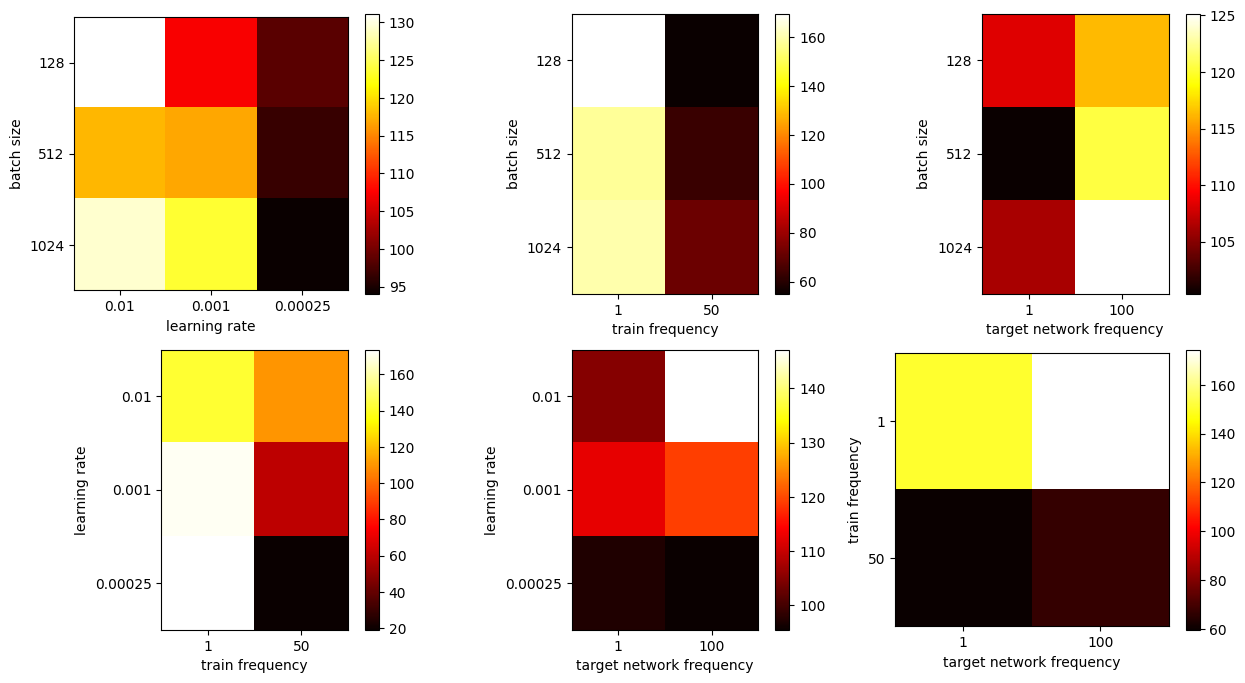

In [65]:
names = ["batch size", "learning rate", "train frequency", "target network frequency"]
arrays = [batch_sizes, learning_rates, train_frequencies, target_network_frequencies]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
cnt = 0
for i in range (len(names)):
    for j in range(i + 1, len(names)):
        row = cnt // 3
        col = cnt % 3
        ax = axes[row, col]
        ax.set_ylabel(names[i])
        ax.set_xlabel(names[j])
        ax.set_xticks(range(len(arrays[j])))
        ax.set_xticklabels(arrays[j])
        ax.set_yticks(range(len(arrays[i])))
        ax.set_yticklabels(arrays[i])
        # # add legend
        indices = list(range(len(names)))
        indices.remove(i)
        indices.remove(j)
        cbar = ax.figure.colorbar(ax.imshow(results.mean(axis=tuple(indices)), cmap='hot', interpolation='nearest'))
        cnt += 1
plt.show()

In [17]:
TARGET_NETWORK_FREQ = 100
TRAIN_FREQ = 1
LEARNING_RATE = 2.5e-4
BATCH_SIZE = 128
logging.info(f"""reward sum: {results[0, 2, 0, 1]}""")

2024-01-25 17:19:51 INFO     reward sum: 4286.642578125


### LMC DQN

In [61]:
q_network = QNetwork(n_actions=env.num_actions, **Q_NETWORK_CONFIG)

slgd_updates_per_steps = [1, 2, 4, 10]
bias_factors = [-1, 1, 2, 4, 10]
tempeartures = jnp.array([1e-2, 1e-3, 1e-4, 1e-8])
results = np.zeros((len(slgd_updates_per_steps), len(bias_factors), len(tempeartures)))
for i, update_step in enumerate(slgd_updates_per_steps):
  for j, bias_factor in enumerate(bias_factors):
    lmc_dqn_train = jax.jit(make_lmc_dqn_train(env=env, q_network=q_network, num_envs=NUM_ENVS,
                                           buffer_size=DQN_BUFFER_SIZE, batch_size=BATCH_SIZE,
                                           steps=EPISODES * HORIZON, slgd_updates_per_step=update_step,
                                           bias_factor=bias_factor))
    rngs = jax.random.split(jax.random.PRNGKey(SEED), 4)
     # shape: (n_rngs, n_temperatures, n_steps, n_envs, ...)
    state, metrics = jax.vmap(jax.vmap(lmc_dqn_train, (None, None, 0, None, None)), (0, None, None, None, None))(rngs, LEARNING_RATE, tempeartures, TRAIN_FREQ, TARGET_NETWORK_FREQ)
    final_rewards = metrics["info"]["returned_episode_returns"].mean(axis=-1)[..., -200:].sum(axis=-1).mean(axis=0) # shape:  (n_temperatures)
    results[i, j] = final_rewards
    logging.info(f"update_step: {update_step}, bias factor: {bias_factor} done!")

2024-01-25 20:25:07 INFO     update_step: 1, bias factor: -1 done!
2024-01-25 20:25:32 INFO     update_step: 1, bias factor: 1 done!
2024-01-25 20:25:59 INFO     update_step: 1, bias factor: 2 done!
2024-01-25 20:26:24 INFO     update_step: 1, bias factor: 4 done!
2024-01-25 20:26:48 INFO     update_step: 1, bias factor: 10 done!
2024-01-25 20:27:17 INFO     update_step: 2, bias factor: -1 done!
2024-01-25 20:27:45 INFO     update_step: 2, bias factor: 1 done!
2024-01-25 20:28:15 INFO     update_step: 2, bias factor: 2 done!
2024-01-25 20:28:44 INFO     update_step: 2, bias factor: 4 done!
2024-01-25 20:29:12 INFO     update_step: 2, bias factor: 10 done!
2024-01-25 20:29:47 INFO     update_step: 4, bias factor: -1 done!
2024-01-25 20:30:22 INFO     update_step: 4, bias factor: 1 done!
2024-01-25 20:30:57 INFO     update_step: 4, bias factor: 2 done!
2024-01-25 20:31:31 INFO     update_step: 4, bias factor: 4 done!
2024-01-25 20:32:08 INFO     update_step: 4, bias factor: 10 done!
2024

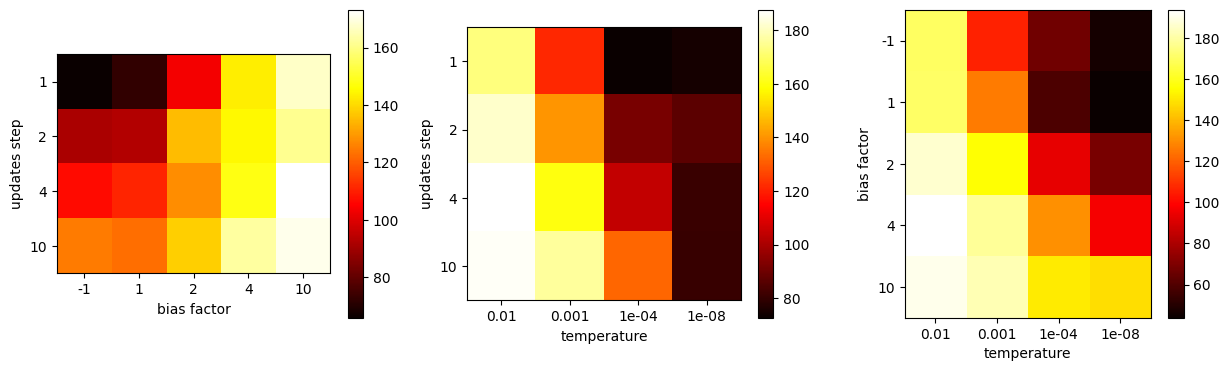

In [62]:
names = ["updates step", "bias factor", "temperature"]
arrays = [slgd_updates_per_steps, bias_factors, tempeartures]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
cnt = 0
for i in range (len(names)):
    for j in range(i + 1, len(names)):
        ax = axes[cnt]
        ax.set_ylabel(names[i])
        ax.set_xlabel(names[j])
        ax.set_xticks(range(len(arrays[j])))
        ax.set_xticklabels(arrays[j])
        ax.set_yticks(range(len(arrays[i])))
        ax.set_yticklabels(arrays[i])
        # # add legend
        indices = list(range(len(names)))
        indices.remove(i)
        indices.remove(j)
        cbar = ax.figure.colorbar(ax.imshow(results.mean(axis=tuple(indices)), cmap='hot', interpolation='nearest'))
        cnt += 1
plt.show()

In [39]:
SLGD_UPDATES_PER_STEP = 4
BIAS_FACTOR = 4
TEMPERATURE = 0.01
logging.info(f"""reward sum: {results[2, 3, 0]}""")

2024-01-25 20:15:59 INFO     reward sum: 6327.74267578125


### Max-Entropy LMC DQN

In [ ]:
q_network = QNetwork(n_actions=env.num_actions, **Q_NETWORK_CONFIG)
MAX_ENT_EPSILON = 1e-4


max_ent_prior_n_samples = [500, 1000, 2000]
max_ent_updates_per_steps = [100, 500, 1000]
max_ent_updates_frequencies = [10, 100]
max_ent_lambdas = jnp.array([0.1, 1, 1, 100])
expert_betas = jnp.array([0.1, 1, 10])
max_ent_learning_rates = jnp.array([5e-2, 1e-2, 1e-3])

results = np.zeros((len(max_ent_prior_n_samples), len(max_ent_updates_per_steps), len(max_ent_updates_frequencies), len(max_ent_lambdas), len(expert_betas), len(max_ent_learning_rates)))

for i, max_ent_prior_n_sample in enumerate(max_ent_prior_n_samples):
  for j, max_ent_updates_per_step in enumerate(max_ent_updates_per_steps):
    for k, max_ent_updates_frequency in enumerate(max_ent_updates_frequencies):
      lmc_dqn_train = jax.jit(make_max_ent_dqn_train(env=env, q_network=q_network, num_envs=NUM_ENVS,
                                                      buffer_size=DQN_BUFFER_SIZE, batch_size=BATCH_SIZE,
                                                      steps=EPISODES * HORIZON, slgd_updates_per_step=SLGD_UPDATES_PER_STEP,
                                                      bias_factor=BIAS_FACTOR, max_ent_prior_n_samples=max_ent_prior_n_sample,
                                                      max_ent_updates_per_step=max_ent_updates_per_step,))

      hyper_lmc_dqn_train = jax.vmap(jax.vmap(jax.vmap(jax.vmap(lmc_dqn_train,
                                                                10 * [None] + [0]),
                                                       )))
      rngs = jax.random.split(jax.random.PRNGKey(SEED), 4)
        # shape: (n_rngs, n_temperatures, n_steps, n_envs, ...)
      state, metrics = hyper_lmc_dqn_train(rngs, expert_trajectories, LEARNING_RATE, TEMPERATURE, TRAIN_FREQ,
                                           TARGET_NETWORK_FREQ, max_ent_lambdas, MAX_ENT_EPSILON, max_ent_learning_rates,
                                           max_ent_updates_frequency, expert_betas)
      final_rewards = metrics["info"]["returned_episode_returns"].mean(axis=-1)[..., -200:].sum(axis=-1).mean(axis=0) # shape:  (n_temperatures)
      results[i, j] = final_rewards
      logging.info(f"update_step: {update_step}, bias factor: {bias_factor} done!")

## Environment

## Generate Expert Trajectories

In [ ]:
from experior.experts import generate_optimal_trajectories

In [ ]:
jax.config.update("jax_disable_jit", False)
rng = PRNGSequence(42)
expert_trajectories = generate_optimal_trajectories(next(rng),
                                                    env,
                                                    expert_config["n_trajectories"],
                                                    env_config["horizon"])

## Deep Q-Network

In [ ]:
from experior.rl_agents import make_dqn_train
q_network = QNetwork(n_actions=env.num_actions, **q_network_config)
dqn_train = make_dqn_train(env=env, q_network=q_network, num_envs=env_config["num_envs"], **dqn_config)

In [ ]:
jax.config.update("jax_disable_jit", False)
dqn_train = jax.jit(dqn_train)
runner_state, dqn_output = dqn_train(jax.random.PRNGKey(4536))

In [ ]:
import matplotlib.pyplot as plt
per_episode_reward = dqn_output["info"]["returned_episode_returns"][::env_config["horizon"]].mean(-1).reshape(-1)
plt.plot(moving_average(per_episode_reward, 20))

## Adam LMCDQN

In [ ]:
from experior.rl_agents import make_lmc_dqn_train
q_network = QNetwork(n_actions=env.num_actions, **q_network_config)
lmc_dqn_train = make_lmc_dqn_train(env=env, q_network=q_network, num_envs=env_config["num_envs"], **lmc_dqn_config)

In [ ]:
jax.config.update("jax_disable_jit", False)
lmc_dqn_train = jax.jit(lmc_dqn_train)
runner_state, lmc_dqn_output = lmc_dqn_train(jax.random.PRNGKey(4536))

In [ ]:
import matplotlib.pyplot as plt
per_episode_reward = lmc_dqn_output["info"]["returned_episode_returns"][::env_config["horizon"]].mean(-1).reshape(-1)
plt.plot(moving_average(per_episode_reward, 20))


## Max-Entropy LMC DQN

In [ ]:
from experior.rl_agents import make_max_ent_dqn_train
q_network = QNetwork(n_actions=env.num_actions, **q_network_config)
max_ent_dqn_train = make_max_ent_dqn_train(env=env, q_network=q_network, num_envs=env_config["num_envs"], **max_ent_dqn_config)

In [ ]:
jax.config.update("jax_disable_jit", False)
max_ent_dqn_train = jax.jit(max_ent_dqn_train)
runner_state, max_ent_output = max_ent_dqn_train(jax.random.PRNGKey(4536), expert_trajectories)

In [ ]:
import matplotlib.pyplot as plt
per_episode_reward = max_ent_output["info"]["returned_episode_returns"][::env_config["horizon"]].mean(-1).reshape(-1)
plt.plot(moving_average(per_episode_reward, 20))

## All Final Results

In [ ]:
window_size = 100
plt.plot(moving_average(dqn_output['reward'].mean(axis=-1).reshape(-1, env_config["horizon"]).sum(axis=-1), window_size), label="DQN")
plt.plot(moving_average(lmc_dqn_output['reward'].mean(axis=-1).reshape(-1, env_config["horizon"]).sum(axis=-1), window_size), label="Langevin with Standard Gaussian Prior")
plt.plot(moving_average(max_ent_output['reward'].mean(axis=-1).reshape(-1, env_config["horizon"]).sum(axis=-1), window_size), label="Langevin with Max Ent Prior")

plt.xlabel("Episodes")
plt.ylabel("Avg Reward per Episode")
plt.title("DeepSea Environment")
plt.legend()

plt.show()

## PPO

In [ ]:
from experior.rl_agents import make_discrete_ppo_train
actor_critic_network = ActorCritic(action_dim=env.action_space(env.default_params).n,
                                   activation="relu")

ppo_train = make_discrete_ppo_train(env=env,
                                    actor_critic_network=actor_critic_network,
                                    num_envs=env_config["num_envs"],
                                    **ppo_config)

In [ ]:
jax.config.update("jax_disable_jit", False)
ppo_train = jax.jit(ppo_train)
state, ppo_output = ppo_train(jax.random.PRNGKey(4536))

In [ ]:
import matplotlib.pyplot as plt
per_episode_reward = ppo_output["metrics"]["returned_episode_returns"].mean(-1).reshape(-1)
plt.plot(moving_average(per_episode_reward, 20))

In [ ]:

EPISODES = 2000
env_config = {
  "horizon": 10,
  "num_envs": 5,
}

expert_config = {
  "mc_samples": -1,
  "n_trajectories": 1000,
}

q_network_config = {
  "n_hidden": 32,
  "n_features": 16,
}

dqn_config = {
  "buffer_size": 10000,
  "target_network_frequency": 10,
  "batch_size": 128,
  "start_epsilon": 1.0,
  "end_epsilon": 0.05,
  "exploration_fraction": 0.5,
  "learning_starts": 1,
  "train_frequency": 5,
  "steps": env_config["horizon"] * EPISODES,
  "discount_factor": 1.,
  "learning_rate": 2.5e-4,
}

lmc_dqn_config = {
  "buffer_size": 10000,
  "target_network_frequency": 10,
  "batch_size": 128, # TODO Batch Size is less before start - fix it
  "train_frequency": 1,
  "steps": env_config["horizon"] * EPISODES,
  "discount_factor": 1.,
  "learning_rate": 2.5e-4,
  "temperature": 2e-3, # TODO test with multiple hyperparams + maybe multiple updates per epoch + evaluation vs training + episode v.s. horizon
}

# TODO why for the case of no hidden confounder, it does not converge instantly?

max_ent_dqn_config = {
  "buffer_size": 10000,
  "target_network_frequency": 10,
  "batch_size": 128,
  "train_frequency": 1,
  "steps": env_config["horizon"] * EPISODES,
  "discount_factor": 1.,
  "learning_rate": 2.5e-4,
  "temperature": 2e-3,
  "max_ent_lambda": 100,
  "max_ent_epsilon": 1e-3,
  "max_ent_learning_rate": 5e-2,
  "max_ent_prior_n_samples": 500,
  "max_ent_updates_per_step": 100,
  "max_ent_updates_frequency": 10,
  "expert_beta": 10.0,
  "slgd_updates_per_step": 1
}

num_actors = 10
ppo_config = {
  "learning_rate": 2.5e-4,
  "steps": env_config["horizon"] * EPISODES,
  "train_frequency": env_config["horizon"],
  "num_actors": num_actors,
  "max_grad_norm": 1.,
  "epochs_per_iteration": 4,
  "num_minibatches": 4,
  "ent_coef": 0.1
}